In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sunpy.net import Fido, attrs as a
import astropy.units as u
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import numpy as np
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib import colors

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', (
    # Edit this gradient at https://eltos.github.io/gradient/#cmap=6B80FF-FFFFFF-FF3960
    (0.000, (0.420, 0.502, 1.000)),
    (0.500, (1.000, 1.000, 1.000)),
    (1.000, (1.000, 0.224, 0.376))))

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', (
    # Edit this gradient at https://eltos.github.io/gradient/#cmap=000000-D6D6D6-FFFFFF
    (0.000, (0.000, 0.000, 0.000)),
    (0.500, (0.839, 0.839, 0.839)),
    (1.000, (1.000, 1.000, 1.000))))

sunpy.net.Fido

Fido is a unified data search and retrieval tool.

It provides simultaneous access to a variety of online data sources, some
cover multiple instruments and data products like the Virtual Solar
Observatory and some are specific to a single source.

For details of using `~sunpy.net.Fido` see :ref:`sunpy-tutorial-acquiring-data-index`.


      Client      ...
----------------- ...
CDAWEBClient      ...
EVEClient         ...
GBMClient         ...
XRSClient         ...
SUVIClient        ...
GONGClient        ...
LYRAClient        ...
NOAAIndicesClient ...
NOAAPredictClient ...
SRSClient         ...
NoRHClient        ...
RHESSIClient      ...
HEKClient         ...
HECClient         ...
JSOCClient        ...
VSOClient         ...


Files Downloaded: 100%|██████████| 1/1 [00:01<00:00,  1.90s/file]


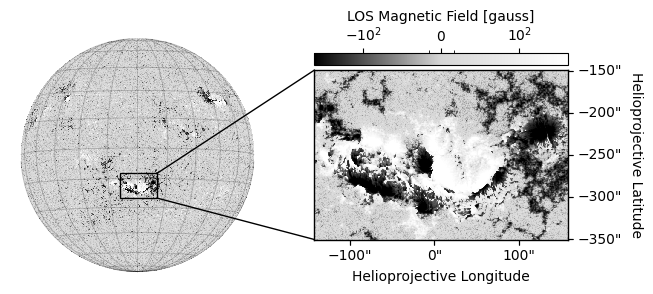

xmax, ymax, zmax 219.328 146.464 20.0
xmax_Mm, ymax_Mm, zmax_Mm 219.328 146.464 20.0
nresol_x, nresol_y, nresol_z 596 398 222
pixelsize_x, pixelsize_x_Mm 0.368 0.368
pixelsize_y, pixelsize_y_Mm 0.368 0.368
pixelsize_z, pixelsize_z_Mm 0.368 0.368


In [4]:
print(Fido)
result = Fido.search(
    a.Time("2024/5/07 07:30:00", "2024/5/07 07:31"),
    a.Instrument.hmi,
    a.Physobs("LOS_magnetic_field"),
)

downloaded_files = Fido.fetch(result)
path = "/Users/lilli/sunpy/data/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram.fits"
hmi_image = sunpy.map.Map(path).rotate()
hdr = hmi_image.fits_header

left_corner = SkyCoord(
    Tx=-142 * u.arcsec, Ty=-350 * u.arcsec, frame=hmi_image.coordinate_frame
)
right_corner = SkyCoord(
    Tx=158 * u.arcsec, Ty=-150 * u.arcsec, frame=hmi_image.coordinate_frame
)


dist = hdr["DSUN_OBS"]
pixelsize_x_unit = hdr["CUNIT1"]
pixelsize_y_unit = hdr["CUNIT2"]
pixelsize_x_arcsec = hdr["CDELT1"]
pixelsize_y_arcsec = hdr["CDELT2"]

if not pixelsize_x_unit == pixelsize_y_unit:
    print("Pixelsize units not matchy-matchy")
    raise ValueError
if not pixelsize_x_arcsec == pixelsize_y_arcsec:
    print("Data pixelsizes in x and y direction not matchy-matchy")
    raise ValueError
else:
    pixelsize_radians = pixelsize_x_arcsec / 206265.0
dist_km = dist / 1000.0
pixelsize_Mm = np.floor(pixelsize_radians * dist_km) * 10**-3

hpc_coords = sunpy.map.all_coordinates_from_map(hmi_image)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
magnetogram_big = sunpy.map.Map(hmi_image.data, hmi_image.meta, mask=mask)

fig = plt.figure(figsize=(7.2, 4.8))
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax1 = fig.add_subplot(121, projection=magnetogram_big)
magnetogram_big.plot(
    axes=ax1,
    cmap=cmap,
    norm=norm,
    annotate=False,
)
magnetogram_big.draw_grid(axes=ax1, color="black", alpha=0.25, lw=0.5)

for coord in ax1.coords:
    coord.frame.set_linewidth(0)
    coord.set_ticks_visible(False)
    coord.set_ticklabel_visible(False)

magnetogram_big.draw_quadrangle(
    left_corner, top_right=right_corner, edgecolor="black", lw=1
)
magnetogram_small = hmi_image.submap(left_corner, top_right=right_corner)
ax2 = fig.add_subplot(122, projection=magnetogram_small)
im = magnetogram_small.plot(
    axes=ax2,
    norm=norm,
    cmap=cmap,
    annotate=False,
)
ax2.grid(alpha=0)
lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lon.set_axislabel(
    "Helioprojective Longitude",
)
lon.set_ticks_position("b")
lat.set_axislabel(
    "Helioprojective Latitude",
)
lat.set_axislabel_position("r")
lat.set_ticks_position("r")
lat.set_ticklabel_position("r")
xpix, ypix = magnetogram_big.wcs.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0, 1),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=1,
)
xpix, ypix = magnetogram_big.wcs.world_to_pixel(
    SkyCoord(right_corner.Tx, left_corner.Ty, frame=magnetogram_big.coordinate_frame)
)
con2 = ConnectionPatch(
    (0, 0),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=1,
)
ax2.add_artist(con1)
ax2.add_artist(con2)

pos = ax2.get_position().get_points()
cax = fig.add_axes([pos[0, 0], pos[1, 1] + 0.01, pos[1, 0] - pos[0, 0], 0.025])
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.locator = matplotlib.ticker.FixedLocator([-1e2, 0, 1e2])
cbar.set_label("LOS Magnetic Field [gauss]", labelpad=-40, rotation=0)
cbar.update_ticks()
cbar.ax.xaxis.set_ticks_position("top")
plotname = "/Users/lilli/Desktop/Paper/SDO_07052022.png"
plt.savefig(plotname, dpi=600, bbox_inches='tight')
plt.show()

nresol_x = magnetogram_small.data.shape[1]
nresol_y = magnetogram_small.data.shape[0]

xmax_Mm = nresol_x * pixelsize_Mm
ymax_Mm = nresol_y * pixelsize_Mm
pixelsize_z_Mm = 90.0 * 10**-3

zmax_Mm = 20000.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

xmax = xmax_Mm
ymax = ymax_Mm
zmax = zmax_Mm
z0 = z0

pixelsize_x = pixelsize_Mm
pixelsize_y = pixelsize_Mm
pixelsize_z = pixelsize_Mm
print("xmax, ymax, zmax", xmax, ymax, zmax)
print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x, pixelsize_x_Mm", pixelsize_x, pixelsize_Mm)
print("pixelsize_y, pixelsize_y_Mm", pixelsize_y, pixelsize_Mm)
print("pixelsize_z, pixelsize_z_Mm", pixelsize_z, pixelsize_Mm)

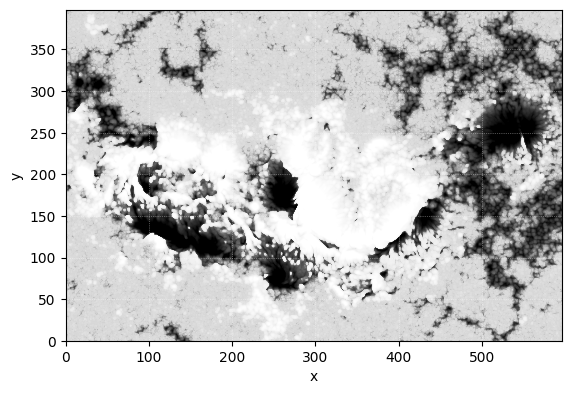

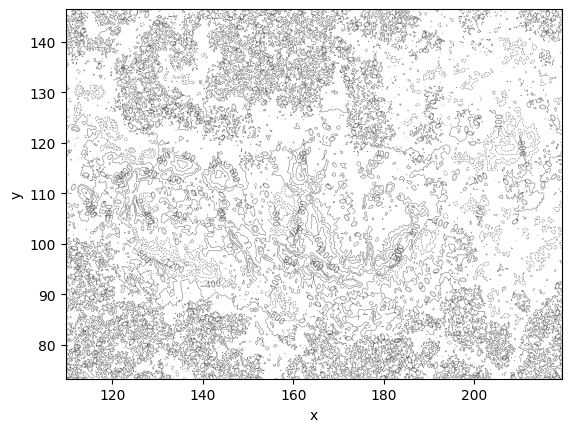

In [5]:
x_arr = np.arange(nresol_x) * (nresol_x) / (nresol_x - 1)
y_arr = np.arange(nresol_y) * (nresol_y) / (nresol_y - 1)
x_plot = np.outer(y_arr, np.ones(nresol_x))
y_plot = np.outer(x_arr, np.ones(nresol_y)).T

fig = plt.figure()
ax = fig.add_subplot(111)
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax.grid(color="white", alpha=0.6, linestyle="dotted", linewidth=0.5)
ax.contourf(y_plot, x_plot, magnetogram_small.data, 1000, norm=norm, cmap=cmap)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(ymax / xmax)
plt.show()

from mflex.classes.clsmod import DataBz

data = DataBz(
    magnetogram_small.data,
    nresol_x,
    nresol_y,
    nresol_z,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    nf_max,
    xmin,
    xmax,
    ymin,
    ymax,
    zmin,
    zmax,
    z0,
)

data_bz = data.data_z
x_arr = np.arange(2 * nresol_x) * (xmax - xmin) / (2 * nresol_x - 1) + xmin
y_arr = np.arange(2 * nresol_y) * (ymax - ymin) / (2 * nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    y_grid[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x],
    data_bz,
    10,
    colors="k",
    linewidths=0.4,
    alpha=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=6, inline=True)
plt.show()

In [6]:
z0_b = z0
deltaz_b = z0 / 10.0
L = 1.0
# a = 0.2
# alpha = 0.008
b = 1.0

alpha = 0.0025
a = 0.4

length_scale = float(2.0 * L)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x * L
length_scale_y = 2.0 * nresol_y * pixelsize_y * L

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())

0.43907459505331026


In [7]:
bfield_mhs = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_0.4_0.0025_1.0_bfield3d.npy"
)

dpartial_bfield_mhs = np.load(
    "/Users/lilli/Desktop/Paper/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram_mflex_0.4_0.0025_1.0_dbzdxdydz3d.npy"
)

In [11]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', (
    # Edit this gradient at https://eltos.github.io/gradient/#cmap=000000-A8A8A8-FFFFFF
    (0.000, (0.000, 0.000, 0.000)),
    (0.500, (0.659, 0.659, 0.659)),
    (1.000, (1.000, 1.000, 1.000))))

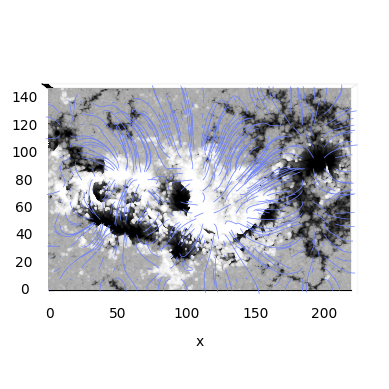

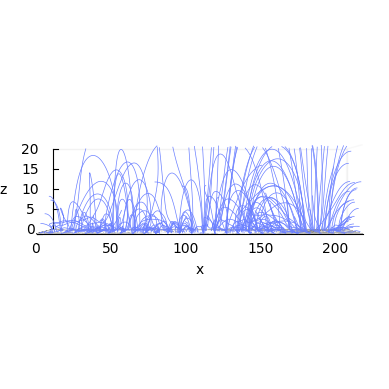

In [19]:
from mflex.plot.plot_magnetogram import plot_fieldlines_sdo_paper

h1 = L / 100.0  # Initial step length for fieldline3D
eps = 1.0e-8
# Tolerance to which we require point on field line known for fieldline3D
hmin = 0.0  # Minimum step length for fieldline3D
hmax = L  # Maximum step length for fieldline3D

plot_fieldlines_sdo_paper(
    bfield_mhs,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    stepsize=8.0,
    view="top",
    cmap=cmap,
)

plot_fieldlines_sdo_paper(
    bfield_mhs,
    h1,
    hmin,
    hmax,
    eps,
    nresol_x,
    nresol_y,
    nresol_z,
    -xmax,
    xmax,
    -ymax,
    ymax,
    zmin,
    zmax,
    a,
    b,
    alpha,
    stepsize=8.0,
    view="side",
    cmap=cmap,
)

In [10]:
dden_mhs = np.load("/Users/lilli/Desktop/Paper/dden_sdo_mhs.npy")
dpres_mhs = np.load("/Users/lilli/Desktop/Paper/dpres_sdo_mhs.npy")

In [11]:
dden_mhs2 = np.load("/Users/lilli/Desktop/Paper/dden_sdo_mhs2.npy")
dpres_mhs2 = np.load("/Users/lilli/Desktop/Paper/dpres_sdo_mhs2.npy")

dden_lff = np.load("/Users/lilli/Desktop/Paper/dden_sdo_lff.npy")
dpres_lff = np.load("/Users/lilli/Desktop/Paper/dpres_sdo_lff.npy")

In [12]:
from mflex.model.plasma_parameters import bpressure, bdensity

z0 = 2.0
deltaz = 0.2
t_photosphere = 5500.0
t_corona = 2.0 * 10.0**6
t0 = (t_photosphere + t_corona * np.tanh(z0 / deltaz)) / (1.0 + np.tanh(z0 / deltaz))
t1 = (t_corona - t_photosphere) / (1.0 + np.tanh(z0 / deltaz))
g_solar = 272.2  # kg/m^3
kB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
mbar = 1.67262 * 10**-27  # mean molecular weight (proton mass)
h = (
    kB * t0 / (mbar * g_solar) * 10**-6 / L  # h' = h / L
)  # pressure scale height in normalised length scale (10**-6 to convert to Mm, and L**-1 to convert to normalised length scale)
rho0 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
b0 = abs(
    data_bz
).max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
p0 = t_photosphere * kB * rho0 / mbar  # plasma pressure in kg/(s^2 m)
mu0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)
pB0 = (b0 * 10**-4) ** 2 / (2 * mu0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)
beta0 = p0 / pB0  # Plasma Beta, ration plasma to magnetic pressure
# h_photo = h / t0 * t_photosphere

print(b0)
print(beta0)

print(p0)
print(pB0)

backpres = 0.0 * z_arr
backden = 0.0 * z_arr

for iz in range(nresol_z):
    z = z_arr[iz]
    backpres[iz] = bpressure(z, z0, deltaz, h, t0, t1)
    backden[iz] = bdensity(z, z0, deltaz, h, t0, t1)

1992.3949315193438
0.7760709971442223
12257.797736485278
15794.686029488783


In [13]:

# Pressure colours

c1 = (0.561, 0.000, 1.000)
c2 = (0.635, 1.000, 0.000)
# Density colours

c3 = (1.000, 0.400, 0.243)
c4 = (0.420, 0.624, 1.000)

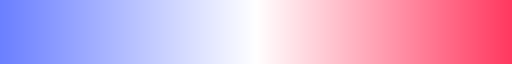

In [14]:
cmap

In [15]:
cmap_pressure = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', (
    # Edit this gradient at https://eltos.github.io/gradient/#cmap=FFFFFF-FF7600
    (0.000, (1.000, 1.000, 1.000)),
    (1.000, (1.000, 0.463, 0.000))))
cmap_density = matplotlib.colors.LinearSegmentedColormap.from_list('', (
    # Edit this gradient at https://eltos.github.io/gradient/#cmap=FFFFFF-FF0070
    (0.000, (1.000, 1.000, 1.000)),
    (1.000, (1.000, 0.000, 0.439))))


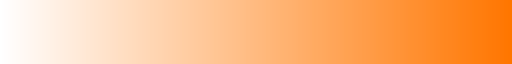

In [16]:
cmap_pressure


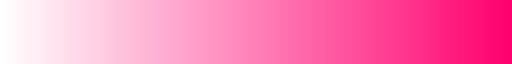

In [17]:
cmap_density

In [18]:
data_bz_norm = (data_bz-np.min(data_bz))/(np.max(data_bz)-np.min(data_bz))


(0, 0, 65)
(147, 306, 0)


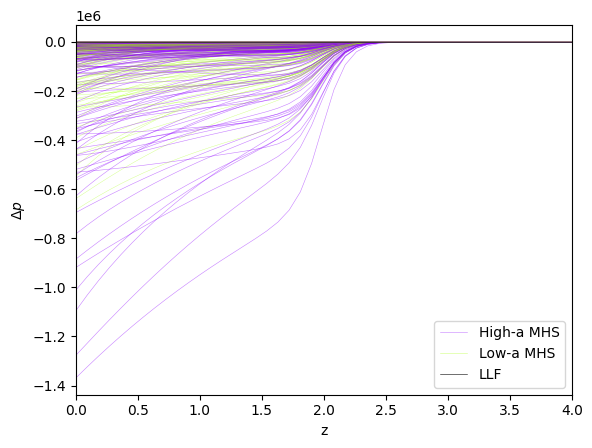

(159, 283, 0)
(160, 278, 0)


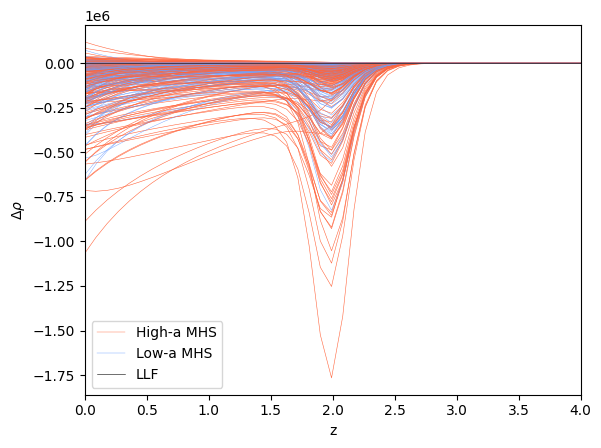

In [19]:
ix_max = np.unravel_index(data_bz.argmax(), data_bz.shape)[1]
iy_max = np.unravel_index(data_bz.argmax(), data_bz.shape)[0]
print(np.unravel_index(dpres_mhs.argmax(), dpres_mhs.shape))
print(np.unravel_index(dpres_mhs.argmin(), dpres_mhs.shape))

plt.plot(
    z_arr,
    dpres_mhs[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c1,
    alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    z_arr,
    dpres_mhs2[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color=c2,
    alpha=0.5,
    label="Low-a MHS",
)
for ix in range(0, nresol_x, 20):
    for iy in range(0, nresol_y, 20):
        plt.plot(
            z_arr,
            dpres_mhs[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c1,
            alpha=0.5,
        )
        plt.plot(
            z_arr,
            dpres_mhs2[iy, ix, :],
            linewidth=0.3,
            linestyle="solid",
            color=c2,
            alpha=0.5,
        )
plt.plot(
    z_arr,
    dpres_lff[0, 0, :],
    linewidth=0.4,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta p$")
plt.xlabel("z")
plt.legend()
# plotname = "/Users/lilli/Desktop/Paper/SDO_dpres.png"
# plt.savefig(plotname, dpi=300)
plt.show()

print(np.unravel_index(dden_mhs.argmax(), dden_mhs.shape))
print(np.unravel_index(dden_mhs.argmin(), dden_mhs.shape))


plt.plot(
    z_arr,
    dden_mhs[0, 0, :],
    linewidth=0.3,
    linestyle="solid",
    color=c3,
    #alpha=0.5,
    label="High-a MHS",
)
plt.plot(
    z_arr,
    dden_mhs2[0, 0, :],
    linewidth=0.3,
    linestyle="solid",
    color=c4,
    #alpha=0.5,
    label="Low-a MHS",
)
for ix in range(0, nresol_x, 20):
    for iy in range(0, nresol_y, 20):
        plt.plot(
            z_arr,
            dden_mhs[iy, ix, :],
            linewidth=0.4,
            linestyle="solid",
            color=c3,
            #alpha=0.5,
        )
        plt.plot(
            z_arr,
            dden_mhs2[iy, ix, :],
            linewidth=0.3,
            linestyle="solid",
            color=c4,
            #alpha=0.5,
        )
plt.plot(
    z_arr,
    dden_lff[iy_max, ix_max, :],
    linewidth=0.4,
    linestyle="solid",
    color="black",
    label="LLF",
)
plt.xlim([0, 2 * z0])
plt.ylabel(r"$\Delta \rho$")
plt.xlabel("z")
plt.legend()
# plotname = "/Users/lilli/Desktop/Paper/SDO_dden.png"
# plt.savefig(plotname, dpi=300)
plt.show()